# Shor 9-Qubit Quantum Error Correction Code

This notebook demonstrates the Shor 9-Qubit Quantum Error Correction Code from Chapter 13, Quantum Error Correction: A Primer.

## 0. Setup

The cells below install the packages and import the libraries needed by this demo.

In [ ]:
#@title Install Qiskit and other dependencies
%pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc ipywidgets matplotlib

In [1]:
# Imports

from math import cos, sin, pi as π
from IPython.display import display, Markdown
from ipywidgets import interact
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit import  ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import ZGate
from qiskit.quantum_info import partial_trace, random_unitary, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

## 1. Circuit Definition

The following cell defines various implementations of the Shor 9-Qubit Quantum Error Correction Code circuit.

While this circuit maintains the same functionality as Figure 13.15 in the QCI textbook, its layout differs for programming convenience. In this implementation, the data qubits are arranged sequentially as $q_1, q_2, \ldots, q_9$ and the ancilla qubits as $a_1, a_2, \ldots, a_8$. In contrast, Figure 13.15 uses the arrangement $q_1, q_2, q_3, a_1, a_2$; $q_4, q_5, q_6, a_3, a_4$; $q_7, q_8, q_9, a_5, a_6$, followed by $a_7, a_8$ for visual clarity.

Refer to **2. Interaction** for configurable options (parameters).


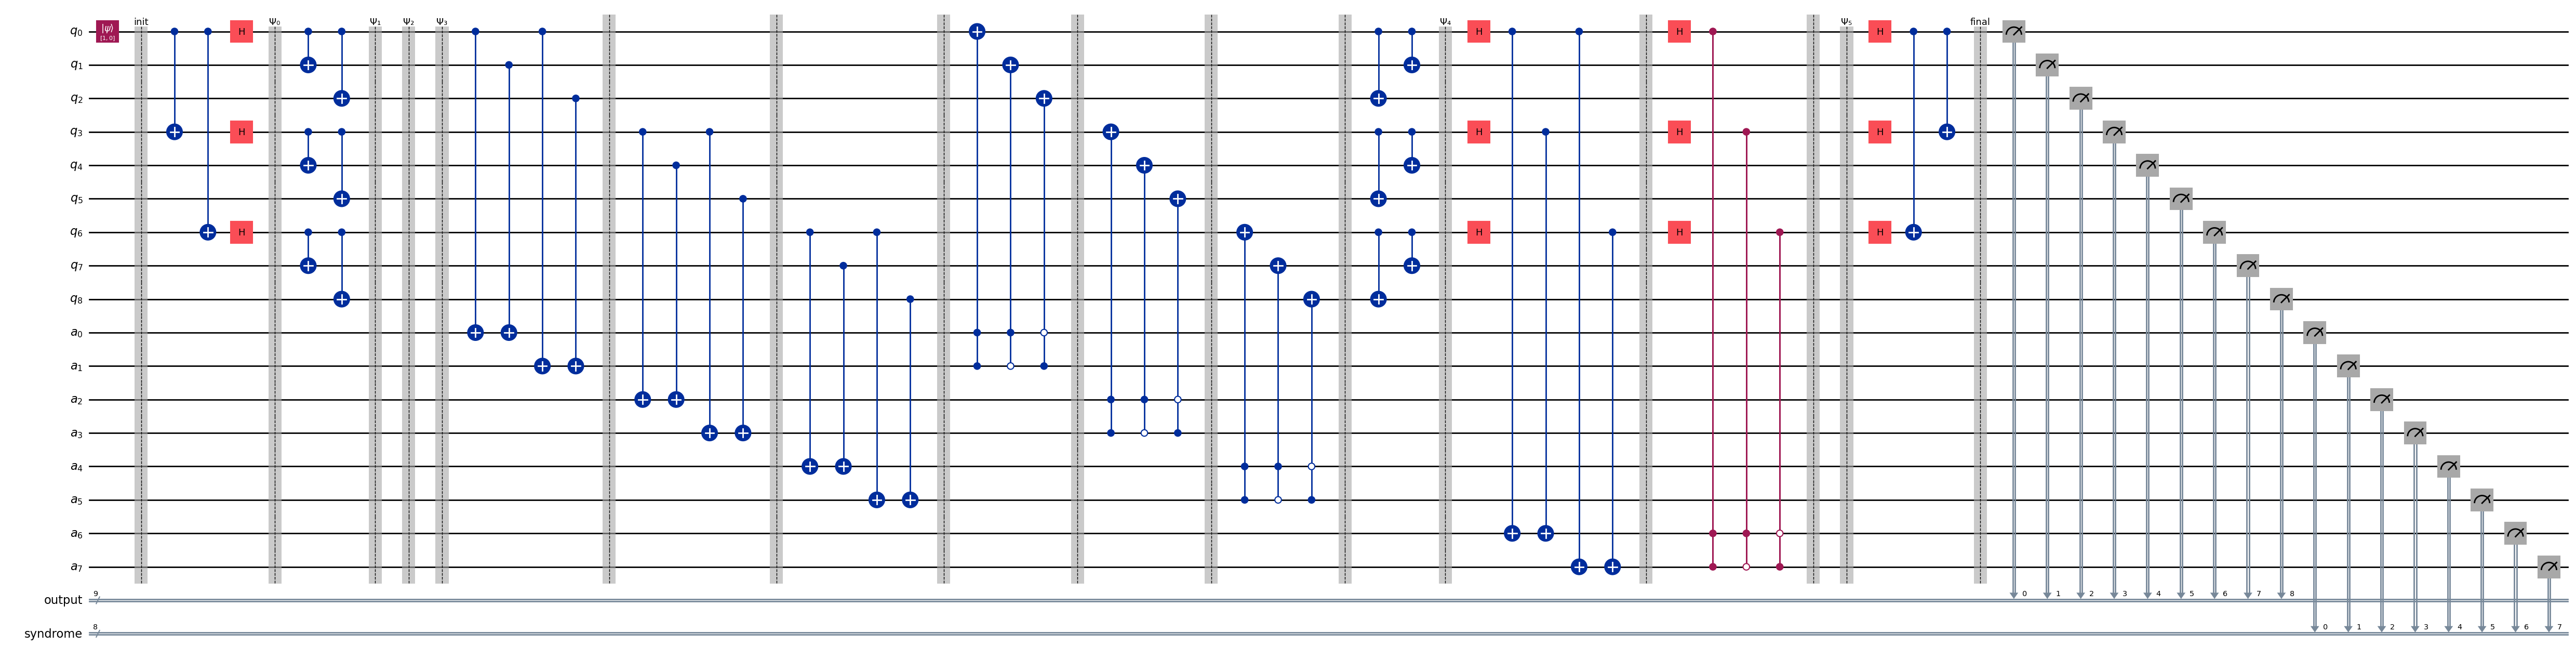

In [14]:


def create_state(θ, φ):
    α = cos(θ/2)
    β = sin(θ/2) * (cos(φ) + 1j * sin(φ)) # exp(iφ) sin(θ/2)
    return Statevector([α, β])


def create_circuit(initial_state = create_state(0, 0), unitary_op=None, error_bit=-1, error_type="X", deferred=True):
    q = [q1, q2, q3, q4, q5, q6, q7, q8, q9] = QuantumRegister(9, name='q')
    a = [a1, a2, a3, a4, a5, a6, a7, a8] = QuantumRegister(8, name='a')
    o = ClassicalRegister(9, name='output')
    s = [s1, s2, s3, s4, s5, s6, s7, s8] = ClassicalRegister(8, name='syndrome')
    circuit = QuantumCircuit(q, a, o, s)

    circuit.initialize(initial_state, q1)
    circuit.save_statevector(label = "init")
    # encode phase flip
    circuit.cx(q1, q4)
    circuit.cx(q1, q7)
    circuit.h([q1, q4, q7])
    circuit.save_statevector(label = "Ψ₀")
    # encode bit flips
    circuit.cx(q1, q2)
    circuit.cx(q1, q3)
    circuit.cx(q4, q5)
    circuit.cx(q4, q6)
    circuit.cx(q7, q8)
    circuit.cx(q7, q9)
    circuit.save_statevector(label = "Ψ₁")
    # apply unitary operation if any selected
    if unitary_op == 'X':
        circuit.z(q1)
        circuit.z(q4)
        circuit.z(q7)
    if unitary_op == 'Z':
        circuit.x(q1)
        circuit.x(q2)
        circuit.x(q3)
    circuit.save_statevector(label = "Ψ₂")
    # apply error if any selected
    if error_bit != -1:
        if error_type == "X":
            circuit.x(q[error_bit])
        if error_type == "Y":
            circuit.y(q[error_bit])
        if error_type == "Z":
            circuit.z(q[error_bit])
        if error_type == "H":
            circuit.h(q[error_bit])
        if error_type == "random":
            random_rotation = random_unitary(2)
            circuit.append(random_rotation, [q[error_bit]])
    circuit.save_statevector(label = "Ψ₃")
    # bit flips correction
    circuit.cx(q1, a1)
    circuit.cx(q2, a1)
    circuit.cx(q1, a2)
    circuit.cx(q3, a2)
    circuit.barrier()
    circuit.cx(q4, a3)
    circuit.cx(q5, a3)
    circuit.cx(q4, a4)
    circuit.cx(q6, a4)
    circuit.barrier()
    circuit.cx(q7, a5)
    circuit.cx(q8, a5)
    circuit.cx(q7, a6)
    circuit.cx(q9, a6)
    circuit.barrier()
    if not deferred:
        circuit.measure([a1, a2, a3, a4, a5, a6], [s1, s2, s3, s4, s5, s6])
        with circuit.if_test((s1, 1)):
            with circuit.if_test((s2, 1)):
                circuit.x(q1)
        with circuit.if_test((s1, 1)):
            with circuit.if_test((s2, 0)):
                circuit.x(q2)
        with circuit.if_test((s1, 0)):
            with circuit.if_test((s2, 1)):
                circuit.x(q3)
        circuit.barrier()
        with circuit.if_test((s3, 1)):
            with circuit.if_test((s4, 1)):
                circuit.x(q4)
        with circuit.if_test((s3, 1)):
            with circuit.if_test((s4, 0)):
                circuit.x(q5)
        with circuit.if_test((s3, 0)):
            with circuit.if_test((s4, 1)):
                circuit.x(q6)
        circuit.barrier()
        with circuit.if_test((s5, 1)):
            with circuit.if_test((s6, 1)):
                circuit.x(q7)
        with circuit.if_test((s5, 1)):
            with circuit.if_test((s6, 0)):
                circuit.x(q8)
        with circuit.if_test((s5, 0)):
            with circuit.if_test((s6, 1)):
                circuit.x(q9)
        circuit.barrier()
    else:
        circuit.mcx([a2, a1], q1, ctrl_state=0b11)
        circuit.mcx([a2, a1], q2, ctrl_state=0b10)
        circuit.mcx([a2, a1], q3, ctrl_state=0b01)
        circuit.barrier()
        # circuit.measure(q, o)
        circuit.mcx([a4, a3], q4, ctrl_state=0b11)
        circuit.mcx([a4, a3], q5, ctrl_state=0b10)
        circuit.mcx([a4, a3], q6, ctrl_state=0b01)
        circuit.barrier()
        circuit.mcx([a6, a5], q7, ctrl_state=0b11)
        circuit.mcx([a6, a5], q8, ctrl_state=0b10)
        circuit.mcx([a6, a5], q9, ctrl_state=0b01)
        circuit.barrier()
    # decode bitflips: note this is in a different order from the first edition of the book.
    circuit.cx(q7, q9)
    circuit.cx(q7, q8)
    circuit.cx(q4, q6)
    circuit.cx(q4, q5)
    circuit.cx(q1, q3)
    circuit.cx(q1, q2)
    circuit.save_statevector(label = "Ψ₄")
    # phase flip correction
    circuit.h([q1, q4, q7])
    circuit.cx(q1, a7)
    circuit.cx(q4, a7)
    circuit.cx(q1, a8)
    circuit.cx(q7, a8)
    circuit.barrier()
    circuit.h([q1, q4, q7])
    if not deferred:
        circuit.measure([a7, a8], [s7, s8])
        with circuit.if_test((s7, 1)):
            with circuit.if_test((s8, 1)):
                circuit.z(q1)
        with circuit.if_test((s7, 1)):
            with circuit.if_test((s8, 0)):
                circuit.z(q4)
        with circuit.if_test((s7, 0)):
            with circuit.if_test((s8, 1)):
                circuit.z(q7)
        circuit.barrier()
    else:
        circuit.append(ZGate().control(num_ctrl_qubits=2, ctrl_state=0b11), [a8, a7, q1])
        circuit.append(ZGate().control(num_ctrl_qubits=2, ctrl_state=0b10), [a8, a7, q4])
        circuit.append(ZGate().control(num_ctrl_qubits=2, ctrl_state=0b01), [a8, a7, q7])
        circuit.barrier()
    circuit.save_statevector(label = "Ψ₅")
    # decode phase flip
    circuit.h([q1, q4, q7])
    circuit.cx(q1, q7)
    circuit.cx(q1, q4)
    circuit.save_statevector(label = "final")
    # circuit.barrier()
    circuit.measure(q, o)
    if deferred:
        circuit.measure(a, s)
    return circuit


circuit = create_circuit()
display(circuit.draw(output="mpl", fold=-1, cregbundle=True))

## 2. Interaction

The cell below displays and runs variants of the circuit for the Shor 9-Qubit Quantum Error Correction Code defined in **1. Circuit Definition**, and shows the state vector resulting as each stage of the computation.

You can experiment with $\theta$ and $\phi$ to create a general input state
$$
|\psi\rangle = \cos\frac{\theta}{2}|0\rangle + e^{i\phi}\sin\frac{\theta}{2}|1\rangle
$$
and observe the execution of the circuit.

Some examples are:

| State | $\theta$ | $\phi$ |
|-------|----------|--------|
| $\|0\rangle$ | 0 | 0 |
| $\|1\rangle$ | $\pi$ | 0 |
| $\frac{1}{\sqrt{2}}(\|0\rangle + i\|1\rangle)$ | $\frac{\pi}{2}$ | $\frac{\pi}{2}$ |

You can also experiment with these parameters:

* `unitary_op`: The logical unitary operation to apply to the encoded state: None, `'X'` for $X_L$, or `'Z'` for $Z_L$.
* `error_bit`: Single qubit to apply an error to: -1 = no error, 0-8 = error on qubit 0-8.
* `error_type`: The type of error to apply: None, $X$, $Y$, $Z$, $H$ or "random".
* `deferred`: Build the circuit with deferred measurement, or not.

The $X$ and $Z$ errors are the usual bit flip and phase flip errors, respectively. The $Y$ error is a combination of both. The $H$ error is a superposition of bit flip and phase flip errors, because $H = \frac{1}{\sqrt{2}}(X + Z)$.

In [22]:
def syndrome_ordinal(syndrome):
    if syndrome == "11":
        return "first"
    if syndrome == "01":
        return "second"
    if syndrome == "10":
        return "third"


# Basis state |0⟩
# θ = 0
# φ = 0

# Basis state |1⟩
θ = π
φ = 0

# Another state: 1/√2 (|0⟩ + i|1⟩)
# θ = π/2
# φ = π/2

# Unitary operation: X (optional)
unitary_op = None
# unitary_op = 'X'

# Error bit: -1 is no error, otherwise error on qubit 0, 1, or 2
error_bit = -1
# error_bit = 1

circuit = create_circuit(create_state(θ, φ), unitary_op = unitary_op, error_bit = error_bit)
simulator = AerSimulator()
result = simulator.run(circuit).result()
statevectors = result.data(0)
init = statevectors["init"]
input = partial_trace(init, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]).to_statevector() # extract the state of just the input qubit (q2)
Ψ0 = statevectors["Ψ₀"]
Ψ1 = statevectors["Ψ₁"]
Ψ2 = statevectors["Ψ₂"]
Ψ3 = statevectors["Ψ₃"]
Ψ4 = statevectors["Ψ₄"]
Ψ5 = statevectors["Ψ₅"]
final = statevectors["final"]
output = partial_trace(final, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]).to_statevector() # extract the state of just the output qubit (q0)


def fmt_sv(statevector):
    return statevector.draw('latex_source').replace('|', r'\|') # escape | for use in Markdown table


display(Markdown(f"""Stage | State
---    | ---
Input  | ${fmt_sv(input)}$ (up to a phase difference)
init   | ${fmt_sv(init)}$
Ψ₀     | ${fmt_sv(Ψ0)}$
Ψ₁     | ${fmt_sv(Ψ1)}$
Ψ₂     | ${fmt_sv(Ψ2)}$
Ψ₃     | ${fmt_sv(Ψ3)}$
Ψ₄     | ${fmt_sv(Ψ4)}$
Ψ₅     | ${fmt_sv(Ψ5)}$
Final  | ${fmt_sv(final)}$
Output | ${fmt_sv(output)}$ (up to a phase difference)
"""))


sampler = Sampler(simulator)
job = sampler.run([circuit], shots=1000)
result = job.result()

output_counts = result[0].data.output.get_counts()
print(f"\n{'Output':<10} {'counts':<6}")
for bits, val in sorted(output_counts.items()):
    assert bits[0:8] == "00000000"
    bit = bits[8]
    print(f"{bit:<10} {val:<6}")
print("")

syndrome_counts = result[0].data.syndrome.get_counts()
print(f"{'Syndrome':<10} {'counts':<6}")
for bits, val in sorted(syndrome_counts.items()):
    print(f"{bits:<10} {val:<6}")
print("")

for synd in sorted(set([syndrome[0:2] for syndrome in syndrome_counts])):
    if synd != "00":
        print(f"{synd} found in syndrome positions 6-7 indicates phase flip detected in {syndrome_ordinal(synd)} triplet.")

for synd in sorted(set([syndrome[2:4] for syndrome in syndrome_counts])):
    if synd != "00":
        print(f"{synd} found in syndrome positions 4-5 indicates bit flip detected in {syndrome_ordinal(synd)} qubit of third triplet.")

for synd in sorted(set([syndrome[4:6] for syndrome in syndrome_counts])):
    if synd != "00":
        print(f"{synd} found in syndrome positions 2-3 indicates bit flip detected in {syndrome_ordinal(synd)} qubit of second triplet.")

for synd in sorted(set([syndrome[6:8] for syndrome in syndrome_counts])):
    if synd != "00":
        print(f"{synd} found in syndrome positions 0-1 indicates bit flip detected in {syndrome_ordinal(synd)} qubit of first triplet.")


Stage | State
---    | ---
Input  | $ \|1\rangle$ (up to a phase difference)
init   | $ \|00000000000000001\rangle$
Ψ₀     | $\frac{\sqrt{2}}{4} \|00000000000000000\rangle- \frac{\sqrt{2}}{4} \|00000000000000001\rangle- \frac{\sqrt{2}}{4} \|00000000000001000\rangle+\frac{\sqrt{2}}{4} \|00000000000001001\rangle- \frac{\sqrt{2}}{4} \|00000000001000000\rangle+\frac{\sqrt{2}}{4} \|00000000001000001\rangle+\frac{\sqrt{2}}{4} \|00000000001001000\rangle- \frac{\sqrt{2}}{4} \|00000000001001001\rangle$
Ψ₁     | $\frac{\sqrt{2}}{4} \|00000000000000000\rangle- \frac{\sqrt{2}}{4} \|00000000000000111\rangle- \frac{\sqrt{2}}{4} \|00000000000111000\rangle+\frac{\sqrt{2}}{4} \|00000000000111111\rangle- \frac{\sqrt{2}}{4} \|00000000111000000\rangle+\frac{\sqrt{2}}{4} \|00000000111000111\rangle+\frac{\sqrt{2}}{4} \|00000000111111000\rangle- \frac{\sqrt{2}}{4} \|00000000111111111\rangle$
Ψ₂     | $\frac{\sqrt{2}}{4} \|00000000000000000\rangle- \frac{\sqrt{2}}{4} \|00000000000000111\rangle- \frac{\sqrt{2}}{4} \|00000000000111000\rangle+\frac{\sqrt{2}}{4} \|00000000000111111\rangle- \frac{\sqrt{2}}{4} \|00000000111000000\rangle+\frac{\sqrt{2}}{4} \|00000000111000111\rangle+\frac{\sqrt{2}}{4} \|00000000111111000\rangle- \frac{\sqrt{2}}{4} \|00000000111111111\rangle$
Ψ₃     | $\frac{\sqrt{2}}{4} \|00000000000000000\rangle- \frac{\sqrt{2}}{4} \|00000000000000111\rangle- \frac{\sqrt{2}}{4} \|00000000000111000\rangle+\frac{\sqrt{2}}{4} \|00000000000111111\rangle- \frac{\sqrt{2}}{4} \|00000000111000000\rangle+\frac{\sqrt{2}}{4} \|00000000111000111\rangle+\frac{\sqrt{2}}{4} \|00000000111111000\rangle- \frac{\sqrt{2}}{4} \|00000000111111111\rangle$
Ψ₄     | $\frac{\sqrt{2}}{4} \|00000000000000000\rangle- \frac{\sqrt{2}}{4} \|00000000000000001\rangle- \frac{\sqrt{2}}{4} \|00000000000001000\rangle+\frac{\sqrt{2}}{4} \|00000000000001001\rangle- \frac{\sqrt{2}}{4} \|00000000001000000\rangle+\frac{\sqrt{2}}{4} \|00000000001000001\rangle+\frac{\sqrt{2}}{4} \|00000000001001000\rangle- \frac{\sqrt{2}}{4} \|00000000001001001\rangle$
Ψ₅     | $\frac{\sqrt{2}}{4} \|00000000000000000\rangle- \frac{\sqrt{2}}{4} \|00000000000000001\rangle- \frac{\sqrt{2}}{4} \|00000000000001000\rangle+\frac{\sqrt{2}}{4} \|00000000000001001\rangle- \frac{\sqrt{2}}{4} \|00000000001000000\rangle+\frac{\sqrt{2}}{4} \|00000000001000001\rangle+\frac{\sqrt{2}}{4} \|00000000001001000\rangle- \frac{\sqrt{2}}{4} \|00000000001001001\rangle$
Final  | $ \|00000000000000001\rangle$
Output | $ \|1\rangle$ (up to a phase difference)



Output     counts
1          1000  

Syndrome   counts
00000000   1000  



## 4. Alternative Circuit Definition

The following cell defines various implementations of the Shor 9-Qubit Quantum Error Correction Code circuit, directly mirroring Figure 13.15 in the *Quantum Computing and Information* textbook.

In this circuit, the data qubits and ancilla qubits are interleaved as $q_1, q_2, q_3, a_1, a_2$; $q_4, q_5, q_6, a_3, a_4$; $q_7, q_8, q_9, a_5, a_6$, followed by $a_7, a_8$ for visual clarity. In **1. Circuit Definition**, they are arranged as $q_1, q_2, \ldots, q_9$, $a_1, a_2, \ldots, a_8$ for programming convenience.

Refer to **2. Interaction** for configurable options (parameters).


In [ ]:
# Code TODO

## 5. Simplified Circuit

The Shor code can also be applied to quantum communication, where quantum states are transmitted in the presence of noise. In this case, repeating the middle steps is often unnecessary, allowing for a simplified circuit, as shown in Fig. 13.16 in the QCI Book. In this simplified version, the error correction process can be postponed until after decoding, eliminating the need for ancillary qubits. 


In [ ]:
# Code TODO

## 6. Exercise

Your tasks: Display the circuit diagrams and verify their operations for the circuits defined in **4. Alternative Circuit Definition** and **5. Simplified Circuit**.

In [ ]:
# Code to be provided by readers.